Months after portofolio

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp
import matplotlib.pyplot as plt
import warnings
from scipy.interpolate import PchipInterpolator
warnings.filterwarnings("ignore")

In [3]:
data_path = '../data/monthly/monthly.csv'
monthly_raw_data = pd.read_csv(data_path)

# 将 RETX、ewretd 转为数值型
monthly_raw_data['RETX'] = pd.to_numeric(monthly_raw_data['RETX'], errors='coerce')
monthly_raw_data['ewretd'] = pd.to_numeric(monthly_raw_data['ewretd'], errors='coerce')

# 用 (RETX - ewretd) 得到“超额收益”
monthly_raw_data['RETX'] = monthly_raw_data['RETX'] - monthly_raw_data['ewretd']

# 去除 NaN 以及RETX为C或者B的行
cleaned_data = monthly_raw_data.dropna(subset=['RETX'])
shape_before = monthly_raw_data.shape
cleaned_data = cleaned_data[~cleaned_data['RETX'].isin(['B','C'])]
shape_after = cleaned_data.shape
print(f"RETX为B或C的行有 {shape_before[0] - shape_after[0]} 行，已经被删除。")

# 转换日期
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# 保证每支股票 >= 85 个月的数据
stocks_with_enough_data = cleaned_data.groupby('PERMNO').filter(lambda x: len(x) >= 85)

# 按 (PERMNO, date) 排序
stocks_with_enough_data = stocks_with_enough_data.sort_values(['PERMNO','date']).reset_index(drop=True)
print(f"符合条件的股票数量: {stocks_with_enough_data['PERMNO'].nunique()}")

market_data = cleaned_data.groupby('date')['ewretd'].mean().reset_index()
#计算累计收益,累加计算不用累乘
market_data['cumulative_ewretd'] = market_data['ewretd'].cumsum()

RETX为B或C的行有 58583 行，已经被删除。
符合条件的股票数量: 5191


In [11]:
def calculate_cumulative_excess_returns(group):
    """
    对每只股票按日期顺序,按原文应为加和而非乘积
    """
    # group 已按日期排序
    group['cum_excess_return'] = group['RETX'].rolling(window=12, min_periods=12).sum()
    return group

stocks_with_enough_data = (
    stocks_with_enough_data
    .groupby('PERMNO', group_keys=False)
    .apply(calculate_cumulative_excess_returns)
)

In [12]:
# 定义起始和结束日期
start_date = pd.Timestamp('1938-01-01')

# 生成7个5年的周期
five_year_periods = [start_date + pd.DateOffset(years=5 * i) for i in range(9)]

print("Five-Year Periods:")
for period in five_year_periods:
    print(period)

Five-Year Periods:
1938-01-01 00:00:00
1943-01-01 00:00:00
1948-01-01 00:00:00
1953-01-01 00:00:00
1958-01-01 00:00:00
1963-01-01 00:00:00
1968-01-01 00:00:00
1973-01-01 00:00:00
1978-01-01 00:00:00


In [13]:
all_periods = []  # 用于保存每个测试期(n=1..16)的逐月数据

for start_dt in five_year_periods:
    # 4.1 组合形成日 = 起点前1个月末
    formation_date = start_dt - pd.offsets.MonthEnd(1)
    
    # lookback: 过去1个月区间 [formation_date-12M, formation_date]
    lookback_end = formation_date
    lookback_start = formation_date - pd.DateOffset(months=11)

    # 提取 lookback 区间的数据
    lookback_df = stocks_with_enough_data[
        (stocks_with_enough_data['date'] >= lookback_start) &
        (stocks_with_enough_data['date'] <= lookback_end)
    ].copy()
    if lookback_df.empty:
        # 没数据就跳过
        continue
    
    # 对每只股票取 <= formation_date 最新一条记录
    sub = lookback_df[lookback_df['date'] <= formation_date]
    # 每只股票只保留最后一条(含 cum_excess_return)
    portfolio_data = sub.groupby('PERMNO', group_keys=False).tail(1).copy()
    
    # 排序，选最高35(赢家), 最低35(输家)
    portfolio_data = portfolio_data.sort_values('cum_excess_return', ascending=False)
    # 先删除cum_excess_return缺失的行
    portfolio_data = portfolio_data.dropna(subset=['cum_excess_return'])
    winner_ids = portfolio_data.head(35)['PERMNO']
    loser_ids  = portfolio_data.tail(35)['PERMNO']
    
    # -------------- 日志功能：打印调仓信息 -------------
    print("\n[调仓日期: {}]".format(formation_date.date()))
    print("  Winner组合股票数:", len(winner_ids))
    print("  Loser组合股票数:", len(loser_ids))
    # 如果还想查看具体股票ID，可直接打印 winner_ids.values 等
    # print("  Winner IDs:", winner_ids.values)
    # print("  Loser IDs:", loser_ids.values)
    # -----------------------------------------------
    
    # 4.2 三年持有期 = [start_dt, start_dt+36个月 - 1天]
    hold_start = start_dt
    hold_end   = start_dt + pd.DateOffset(months=60) - pd.Timedelta(days=1)
    
    # 赢家/输家组合 在持有期内的数据
    w_hold = stocks_with_enough_data[
        (stocks_with_enough_data['PERMNO'].isin(winner_ids)) &
        (stocks_with_enough_data['date'] >= hold_start) &
        (stocks_with_enough_data['date'] <= hold_end)
    ].copy()
    l_hold = stocks_with_enough_data[
        (stocks_with_enough_data['PERMNO'].isin(loser_ids)) &
        (stocks_with_enough_data['date'] >= hold_start) &
        (stocks_with_enough_data['date'] <= hold_end)
    ].copy()
    
    # 若两组都无数据，也要存个空表做记录
    if w_hold.empty or l_hold.empty:
        all_periods.append(pd.DataFrame({
            'test_period_start': [start_dt],
            'date': [None],
            'avg_u_w': [np.nan],
            'avg_u_l': [np.nan],
        }))
        continue

    # 4.3 每月组合收益
    # 赢家组合：按月份聚合求均值
    w_monthly = w_hold.groupby('date', as_index=False)['RETX'].mean()
    w_monthly.rename(columns={'RETX':'avg_u_w'}, inplace=True)

    # 输家组合：按月份聚合求均值
    l_monthly = l_hold.groupby('date', as_index=False)['RETX'].mean()
    l_monthly.rename(columns={'RETX':'avg_u_l'}, inplace=True)

    # 生成完整的月末区间
    all_months = pd.date_range(hold_start, hold_end, freq='M')
    hold_months_df = pd.DataFrame({'date':all_months})
    
    # 合并赢家/输家
    merged = (
        hold_months_df
        .merge(w_monthly, on='date', how='left')
        .merge(l_monthly, on='date', how='left')
    )
    
    # 计算累计收益 (CAR_w, CAR_l) = 对 avg_u_* 的累加/累积
    
    # 累加
    merged['CAR_w'] = merged['avg_u_w'].cumsum(skipna=True)
    merged['CAR_l'] = merged['avg_u_l'].cumsum(skipna=True)
    
    # 标注测试期起点
    merged['test_period_start'] = start_dt
    
    all_periods.append(merged)


# 合并所有测试期
all_periods_df = pd.concat(all_periods, ignore_index=True)
# 排序
all_periods_df.sort_values(['test_period_start','date'], inplace=True)

def add_relative_month(df_):
    """
    为单个测试期添加相对月编号 t=1..36。
    """
    df_ = df_.sort_values('date').reset_index(drop=True)
    df_['t'] = np.arange(len(df_)) + 1
    return df_

all_periods_df = all_periods_df.groupby('test_period_start', group_keys=False).apply(add_relative_month)

# 对同一个 t 跨测试期求均值 => ACAR_w, ACAR_l
acar = all_periods_df.groupby('t', as_index=False).agg({
    'CAR_w':'mean',
    'CAR_l':'mean'
})
acar.rename(columns={'CAR_w':'ACAR_w','CAR_l':'ACAR_l'}, inplace=True)
acar['diff'] = acar['ACAR_l'] - acar['ACAR_w']

print("====== ACAR (平均累计收益) ======")
print(acar[['t','ACAR_w','ACAR_l','diff']])  # 只展示主要列



[调仓日期: 1937-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1942-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1947-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1952-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1957-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1962-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1967-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1972-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35

[调仓日期: 1977-12-31]
  Winner组合股票数: 35
  Loser组合股票数: 35
====== ACAR (平均累计收益) ======
     t    ACAR_w    ACAR_l      diff
0    1 -0.033115  0.052660  0.085775
1    2 -0.047813  0.031541  0.079354
2    3 -0.009340  0.049952  0.059293
3    4 -0.002220  0.001086  0.003306
4    5 -0.018510  0.010167  0.028677
5    6  0.008366  0.049733  0.041367
6    7  0.001079  0.037484  0.036404
7    8 -0.005955  0.032563  0.038517
8    9 -0.000892 -0.023153 -0.022260
9   10 -0.006141  0.091255  0.097396
10  11 -0.056735 -0.018240  0.038495
11  12 -0.016812 -0.067548 -0.050

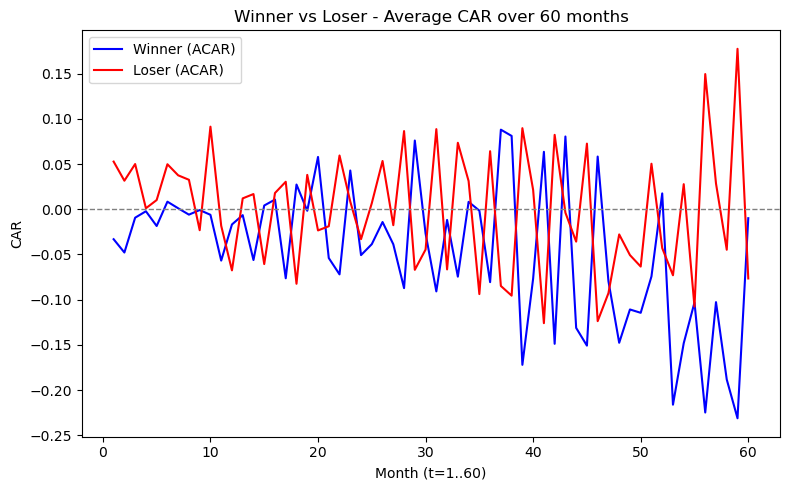

In [15]:
plt.figure(figsize=(8,5))
plt.plot(acar['t'], acar['ACAR_w'], label='Winner (ACAR)', color='blue')
plt.plot(acar['t'], acar['ACAR_l'], label='Loser (ACAR)', color='red')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Month (t=1..60)')
plt.ylabel('CAR')
plt.title('Winner vs Loser - Average CAR over 60 months')
plt.legend()
plt.tight_layout()
plt.show()